In [1]:
from pathlib import Path
import sys

# 1) Trouver la racine du projet (celle qui contient project_paths.py)
PROJECT_ROOT = next(
    p for p in [Path.cwd(), *Path.cwd().parents] if (p / "project_paths.py").exists()
)

# 2) Ajouter la racine au sys.path pour permettre "import project_paths" et "import ..."
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 3) Import des chemins normalisés
from project_paths import ROOT, RAW_DIR, MLRUNS_DIR

print("PROJECT_ROOT =", PROJECT_ROOT)
print("ROOT         =", ROOT)


PROJECT_ROOT = c:\Users\thoma\Documents\Openclassroom\Projet-8
ROOT         = C:\Users\thoma\Documents\Openclassroom\Projet-8


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

import mlflow
import mlflow.sklearn

import importlib
import src.fonctions.fonction_mlflow as fml
import src.fonctions.fonction_recall as fr

importlib.reload(fml)
importlib.reload(fr)

from src.fonctions.fonction_mlflow import run_model, run_model_cv
from src.fonctions.fonction_recall import pick_threshold_for_recall

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [3]:
# Forcer MLflow à écrire dans Projet-8/mlruns
mlflow.set_tracking_uri(f"file:{MLRUNS_DIR.as_posix()}")
mlflow.set_experiment("home-credit-p8-rebuild")

print("MLFLOW_TRACKING_URI =", mlflow.get_tracking_uri())
print("MLRUNS_DIR          =", MLRUNS_DIR)
print("RAW_DIR             =", RAW_DIR)


MLFLOW_TRACKING_URI = file:C:/Users/thoma/Documents/Openclassroom/Projet-8/mlruns
MLRUNS_DIR          = C:\Users\thoma\Documents\Openclassroom\Projet-8\mlruns
RAW_DIR             = C:\Users\thoma\Documents\Openclassroom\Projet-8\data\raw_local


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


In [4]:
path = RAW_DIR / "application_train_features.csv"
df = pd.read_csv(path)

y = df["TARGET"]
X = df.drop(columns=["TARGET"])

print("Loaded:", path)
print("Shape X :", X.shape)
print("Répartition de la cible :")
print(y.value_counts(normalize=True))


Loaded: C:\Users\thoma\Documents\Openclassroom\Projet-8\data\raw_local\application_train_features.csv
Shape X : (307511, 826)
Répartition de la cible :
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

print("Train :", X_train.shape, "Valid :", X_valid.shape)


Train : (246008, 826) Valid : (61503, 826)


In [ ]:
# Active l'autolog pour sklearn (params, modèles, etc.)
mlflow.sklearn.autolog(disable=True)

In [7]:
import inspect
import src.fonctions.fonction_mlflow as fml

print("Pipeline symbol in module:", fml.Pipeline)
print("Type:", type(fml.Pipeline))
print("SimpleImputer:", fml.SimpleImputer)
print("StandardScaler:", fml.StandardScaler)


Pipeline symbol in module: <class 'sklearn.pipeline.Pipeline'>
Type: <class 'abc.ABCMeta'>
SimpleImputer: <class 'sklearn.impute._base.SimpleImputer'>
StandardScaler: <class 'sklearn.preprocessing._data.StandardScaler'>


In [8]:
dummy_clf = DummyClassifier(strategy="most_frequent")

res_dummy = run_model(
    name="baseline_dummy_most_frequent",
    estimator=dummy_clf,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

2026/01/21 15:42:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 15:43:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\O

[baseline_dummy_most_frequent] AUC valid=0.500 | AP valid=0.081 | F1 valid=0.000 (thr=0.5)


In [9]:
logreg = LogisticRegression(
    C=0.1,
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs",
)

res_logreg = run_model(
    name="logreg_baseline",
    estimator=logreg,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)

2026/01/21 15:48:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n

[logreg_baseline] AUC valid=0.776 | AP valid=0.261 | F1 valid=0.281 (thr=0.5)


In [10]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,              # laisse l'arbre se développer
    min_samples_split=10,        # un peu de régularisation
    n_jobs=-1,                   # multi-coeurs
    class_weight="balanced_subsample",  # on reparlera du déséquilibre demain
    random_state=42,
)

res_rf = run_model(
    name="rf_baseline",
    estimator=rf,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)


2026/01/21 15:54:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 15:56:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\O

[rf_baseline] AUC valid=0.746 | AP valid=0.215 | F1 valid=0.010 (thr=0.5)


In [11]:
gbc = GradientBoostingClassifier(
    n_estimators=150,   # pas trop gros pour éviter que ça dure 3h
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)

res_gbc = run_model(
    name="gbc_baseline",
    estimator=gbc,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)


2026/01/21 16:00:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 16:32:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\O

[gbc_baseline] AUC valid=0.780 | AP valid=0.277 | F1 valid=0.059 (thr=0.5)


In [12]:
hgb = HistGradientBoostingClassifier(
    max_depth=None,
    max_leaf_nodes=31,
    learning_rate=0.1,
    random_state=42,
)

res_hgb = run_model(
    name="hgb_baseline",
    estimator=hgb,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)


2026/01/21 16:36:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 16:38:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\O

[hgb_baseline] AUC valid=0.781 | AP valid=0.276 | F1 valid=0.071 (thr=0.5)


In [13]:
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
)

res_xgb = run_model(
    name="xgb_baseline",
    estimator=xgb,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
)


2026/01/21 16:42:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/21 16:44:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\thoma\Documents\O

[xgb_baseline] AUC valid=0.786 | AP valid=0.289 | F1 valid=0.071 (thr=0.5)


In [14]:
dummy_clf = DummyClassifier(strategy="most_frequent")

res_dummy_cv = run_model_cv(
    name="dummy_cv",
    estimator=dummy_clf,
    X=X,
    y=y,
    n_splits=3,
    use_sampling=False,   # IMPORTANT : pas de SMOTE pour le dummy
)


2026/01/21 17:33:16 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2026/01/21 17:33:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
2026/01/21 17:33:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID e8006ef1b6c14f05b19b12717d12459b. Fa

[dummy_cv] AUC OOF=0.500 | AP OOF=0.081 | F1 OOF=0.000 (thr=0.5) | mean folds AUC=0.500, AP=0.081, F1=0.000


In [15]:
logreg_cv = LogisticRegression(
    C=0.1,
    max_iter=1000,
    class_weight=None,   # important ici
    n_jobs=-1,
    solver="lbfgs",
)

res_logreg_cv = run_model_cv(
    name="logreg_cv_smote",
    estimator=logreg_cv,
    X=X,
    y=y,
    n_splits=3,          # ou 5 si tu es patient
    use_sampling=True,
    smote_ratio=0.2,     # minorité ≈ 20% de la majorité dans le train de chaque fold
)


2026/01/21 17:37:15 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 17:37:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 17:37:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 17:37:27 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2026/01/21 17:37:34 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: Future

[logreg_cv_smote] AUC OOF=0.763 | AP OOF=0.242 | F1 OOF=0.275 (thr=0.5) | mean folds AUC=0.763, AP=0.242, F1=0.275


In [16]:
rf_cv = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=10,
    n_jobs=-1,
    class_weight=None,   # on compte sur SMOTE
    random_state=42,
)

res_rf_cv = run_model_cv(
    name="rf_cv_smote",
    estimator=rf_cv,
    X=X,
    y=y,
    n_splits=3,
    use_sampling=True,
    smote_ratio=0.2,
)


2026/01/21 17:44:54 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 17:44:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 17:45:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 17:45:06 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2026/01/21 17:45:14 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2026/01/21 17:45:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added t

[rf_cv_smote] AUC OOF=0.724 | AP OOF=0.192 | F1 OOF=0.267 (thr=0.5) | mean folds AUC=0.724, AP=0.192, F1=0.267


In [17]:
hgb_cv = HistGradientBoostingClassifier(
    max_depth=None,
    max_leaf_nodes=31,
    learning_rate=0.1,
    random_state=42,
    max_iter=100,
)

res_hgb_cv = run_model_cv(
    name="hgb_cv_smote",
    estimator=hgb_cv,
    X=X,
    y=y,
    n_splits=3,
    use_sampling=True,
    smote_ratio=0.2,
)


2026/01/21 17:52:07 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 17:52:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 17:52:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 17:52:23 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2026/01/21 17:52:30 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2026/01/21 17:52:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added t

[hgb_cv_smote] AUC OOF=0.775 | AP OOF=0.260 | F1 OOF=0.323 (thr=0.5) | mean folds AUC=0.775, AP=0.261, F1=0.323


In [18]:
xgb_cv = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
)

res_xgb_cv = run_model_cv(
    name="xgb_cv_smote",
    estimator=xgb_cv,
    X=X,
    y=y,
    n_splits=3,
    use_sampling=True,
    smote_ratio=0.2,
)


2026/01/21 17:59:51 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 17:59:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 18:00:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 18:00:03 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2026/01/21 18:02:19 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:02:20 WARNING mlflow.sklearn: Model was missing function: predict.

[xgb_cv_smote] AUC OOF=0.776 | AP OOF=0.263 | F1 OOF=0.326 (thr=0.5) | mean folds AUC=0.776, AP=0.263, F1=0.326


In [19]:
lgbm_cv = LGBMClassifier(
    objective="binary",
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

res_lgbm_cv_smote = run_model_cv(
    name="lgbm_cv_smote",
    estimator=lgbm_cv,
    X=X,
    y=y,
    n_splits=3,
    use_sampling=True,
    smote_ratio=0.2,    
)


2026/01/21 18:07:22 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:07:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 18:07:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 18:07:33 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 37691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.356985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166606
[LightGBM] [Info] Number of data points in the train set: 75382, number of used features: 787
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 18:09:43 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:09:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 18:09:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 18:09:55 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 37691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.313907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166421
[LightGBM] [Info] Number of data points in the train set: 75382, number of used features: 787
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 18:12:03 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:12:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 18:12:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 18:12:15 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 37691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.372184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 166943
[LightGBM] [Info] Number of data points in the train set: 75382, number of used features: 785
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[lgbm_cv_smote] AUC OOF=0.779 | AP OOF=0.267 | F1 OOF=0.330 (thr=0.5) | mean folds AUC=0.779, AP=0.267, F1=0.330


In [20]:
xgb_cv_smote_under = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",   # obligatoire pour éviter les warnings
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",      # plus rapide sur gros tabulaire
    n_jobs=-1,
    random_state=42,
)

res_xgb_cv_smote_under = run_model_cv(
    name="xgb_cv_smote_under",
    estimator=xgb_cv_smote_under,
    X=X,
    y=y,
    model_name="xgb",
    n_splits=3,          
    use_sampling=True,
    smote_ratio=0.5,     
    use_under=True,
    under_ratio=1.0,     # équilibre final 50/50
)

2026/01/21 18:14:26 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:14:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 18:14:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 18:14:37 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2026/01/21 18:17:47 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:17:47 WARNING mlflow.sklearn: Model was missing function: predict.

[xgb_cv_smote_under] AUC OOF=0.775 | AP OOF=0.263 | F1 OOF=0.210 (thr=0.5) | mean folds AUC=0.775, AP=0.263, F1=0.210


In [21]:
hgb_cv_smote_under = HistGradientBoostingClassifier(
    max_depth=None,
    max_leaf_nodes=31,
    learning_rate=0.1,
    random_state=42,
)

res_hgb_cv_smote_under = run_model_cv(
    name="hgb_cv_smote_under",
    estimator=hgb_cv_smote_under,
    X=X,
    y=y,
    model_name="hgb",
    n_splits=3,
    use_sampling=True,
    smote_ratio=0.5,     
    use_under=True,
    under_ratio=1.0,
)

2026/01/21 18:24:33 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:24:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 18:24:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 18:24:44 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2026/01/21 18:24:53 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2026/01/21 18:25:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added t

[hgb_cv_smote_under] AUC OOF=0.772 | AP OOF=0.258 | F1 OOF=0.199 (thr=0.5) | mean folds AUC=0.772, AP=0.258, F1=0.199


In [22]:
lgbm_cv_smote_under = LGBMClassifier(
    objective="binary",
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

res_lgbm_cv_smote_under = run_model_cv(
    name="lgbm_cv_smote_under",
    estimator=lgbm_cv_smote_under,
    X=X,
    y=y,
    model_name="lgbm",
    n_splits=3,          # reste raisonnable
    use_sampling=True,
    smote_ratio=0.5,     # minorité = 0.5 * majorité après SMOTE
    use_under=True,
    under_ratio=1.0,     # ensuite on coupe la majorité pour arriver à 50/50
)

2026/01/21 18:33:40 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:33:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 18:33:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 18:33:50 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 94228, number of negative: 94228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.828925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179264
[LightGBM] [Info] Number of data points in the train set: 188456, number of used features: 801
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 18:36:37 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:36:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 18:36:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 18:36:48 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 94228, number of negative: 94228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.799915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179823
[LightGBM] [Info] Number of data points in the train set: 188456, number of used features: 801
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 18:39:35 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 18:39:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 18:39:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 18:39:47 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 94229, number of negative: 94229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.807606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180248
[LightGBM] [Info] Number of data points in the train set: 188458, number of used features: 800
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[lgbm_cv_smote_under] AUC OOF=0.779 | AP OOF=0.267 | F1 OOF=0.212 (thr=0.5) | mean folds AUC=0.779, AP=0.268, F1=0.212


In [23]:
# 1) Récupérer le pipeline du dernier fold
pipe_lgbm = res_lgbm_cv_smote["pipeline"]

# 2) Récupérer l’estimateur LightGBM (dernier step "model")
lgbm_model = pipe_lgbm.named_steps["model"]

# 3) Importances de features (LightGBM)
importances = pd.Series(
    lgbm_model.feature_importances_,
    index=X.columns  # même ordre que le fit
).sort_values(ascending=False)

# Regarder les top features
print(importances.head(30))


EXT_SOURCE_3                                         239
EXT_SOURCE_2                                         224
EXT_SOURCE_1                                         180
PAYMENT_RATE                                         163
CODE_GENDER_F                                        133
FLAG_OWN_CAR                                         117
DAYS_BIRTH                                            89
NAME_FAMILY_STATUS_Married                            86
INST_AMT_PAYMENT_MIN                                  85
PREV_DAYS_FIRST_DRAWING_SUM                           83
AMT_ANNUITY                                           83
DAYS_EMPLOYED                                         82
DAYS_ID_PUBLISH                                       81
AMT_GOODS_PRICE                                       72
DEF_30_CNT_SOCIAL_CIRCLE                              71
AMT_CREDIT                                            71
BUREAU_DAYS_CREDIT_MAX                                71
BUREAU_DAYS_ENDDATE_FACT_MAX   

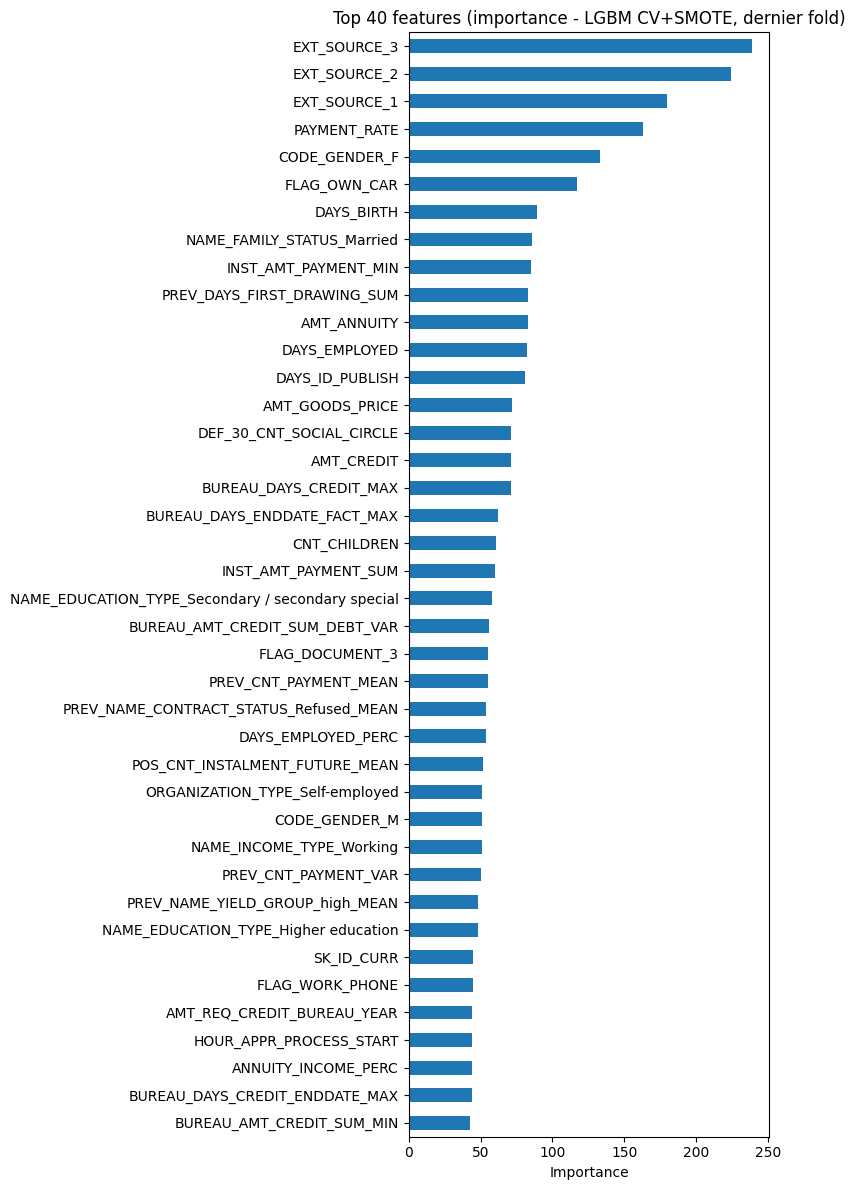

In [24]:
top_k = 40
top_imp = importances.head(top_k)

plt.figure(figsize=(8, 12))
top_imp[::-1].plot(kind="barh")
plt.title("Top 40 features (importance - LGBM CV+SMOTE, dernier fold)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [25]:
imp = importances.copy()  # ta Series triée desc

imp_norm = imp / imp.sum()
cum_imp = imp_norm.cumsum()

cum_imp.head(20), cum_imp.tail(5)


(EXT_SOURCE_3                    0.026556
 EXT_SOURCE_2                    0.051444
 EXT_SOURCE_1                    0.071444
 PAYMENT_RATE                    0.089556
 CODE_GENDER_F                   0.104333
 FLAG_OWN_CAR                    0.117333
 DAYS_BIRTH                      0.127222
 NAME_FAMILY_STATUS_Married      0.136778
 INST_AMT_PAYMENT_MIN            0.146222
 PREV_DAYS_FIRST_DRAWING_SUM     0.155444
 AMT_ANNUITY                     0.164667
 DAYS_EMPLOYED                   0.173778
 DAYS_ID_PUBLISH                 0.182778
 AMT_GOODS_PRICE                 0.190778
 DEF_30_CNT_SOCIAL_CIRCLE        0.198667
 AMT_CREDIT                      0.206556
 BUREAU_DAYS_CREDIT_MAX          0.214444
 BUREAU_DAYS_ENDDATE_FACT_MAX    0.221333
 CNT_CHILDREN                    0.228111
 INST_AMT_PAYMENT_SUM            0.234778
 dtype: float64,
 CCB_NAME_CONTRACT_STATUS_Refused_MEAN          1.0
 CCB_NAME_CONTRACT_STATUS_Sent proposal_MEAN    1.0
 FLAG_EMAIL                            

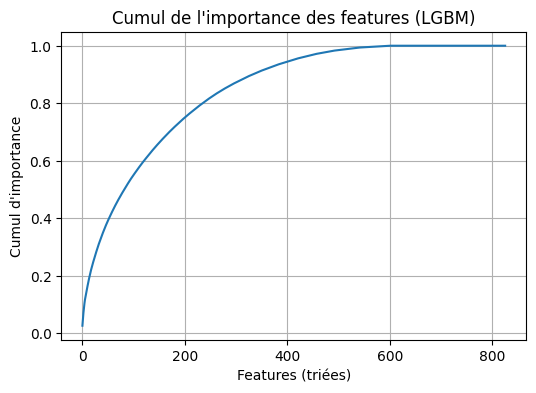

In [26]:
plt.figure(figsize=(6,4))
plt.plot(cum_imp.values)
plt.xlabel("Features (triées)")
plt.ylabel("Cumul d'importance")
plt.title("Cumul de l'importance des features (LGBM)")
plt.grid(True)
plt.show()


In [27]:
# importances = ta Series triée (feature_importances_ de LGBM)
zero_imp = importances[importances == 0.0]
print(f"Nombre de features à importance nulle : {len(zero_imp)}")
print(zero_imp.head(20))


Nombre de features à importance nulle : 227
PREV_NAME_CLIENT_TYPE_XNA_MEAN                              0
PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN            0
PREV_NAME_GOODS_CATEGORY_Animals_MEAN                       0
PREV_NAME_GOODS_CATEGORY_Education_MEAN                     0
PREV_NAME_GOODS_CATEGORY_Fitness_MEAN                       0
PREV_NAME_GOODS_CATEGORY_Homewares_MEAN                     0
PREV_NAME_GOODS_CATEGORY_Insurance_MEAN                     0
PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN                       0
PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN              0
PREV_NAME_GOODS_CATEGORY_Medicine_MEAN                      0
PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN             0
PREV_NAME_GOODS_CATEGORY_Other_MEAN                         0
PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN             0
PREV_NAME_GOODS_CATEGORY_Tourism_MEAN                       0
PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN                      0
PREV_NAME_GOODS_CATEGORY_W

In [28]:
X_nozero = X.drop(columns=zero_imp.index)

print("Shape avant :", X.shape)
print("Shape après :", X_nozero.shape)

df_nozero = X_nozero.copy()
X = X_nozero

Shape avant : (307511, 826)
Shape après : (307511, 599)


In [29]:
lgbm_cv_nozero = LGBMClassifier(
    objective="binary",
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

res_lgbm_cv_smote_nozero = run_model_cv(
    name="lgbm_cv_smote_nozero",
    estimator=lgbm_cv_nozero,
    X=X,   # <- ton X a déjà été remplacé par X_nozero
    y=y,
    model_name="lgbm",
    n_splits=3,
    use_sampling=True,
    smote_ratio=0.2,
    use_under=False,
)


2026/01/21 20:11:11 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 20:11:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 20:11:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 20:11:24 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.010131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146537
[LightGBM] [Info] Number of data points in the train set: 226148, number of used features: 599
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609449
[LightGBM] [Info] Start training from score -1.609449


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 20:15:26 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 20:15:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 20:15:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 20:15:34 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.623400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146321
[LightGBM] [Info] Number of data points in the train set: 226148, number of used features: 599
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609449
[LightGBM] [Info] Start training from score -1.609449


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 20:16:51 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 20:16:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 20:16:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 20:16:58 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.386545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146393
[LightGBM] [Info] Number of data points in the train set: 226149, number of used features: 599
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166664 -> initscore=-1.609454
[LightGBM] [Info] Start training from score -1.609454


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[lgbm_cv_smote_nozero] AUC OOF=0.781 | AP OOF=0.271 | F1 OOF=0.067 (thr=0.5) | mean folds AUC=0.781, AP=0.271, F1=0.067


In [30]:
# Récupérer le pipeline et le modèle LGBM du run "nozero"
pipe_lgbm_nozero = res_lgbm_cv_smote_nozero["pipeline"]
lgbm_model_nozero = pipe_lgbm_nozero.named_steps["model"]

importances_nozero = pd.Series(
    lgbm_model_nozero.feature_importances_,
    index=X.columns,  # ici X = X_nozero
).sort_values(ascending=False)

print(importances_nozero.head(30))


EXT_SOURCE_2                              260
EXT_SOURCE_3                              259
EXT_SOURCE_1                              195
PAYMENT_RATE                              157
CODE_GENDER_F                             145
FLAG_OWN_CAR                              123
DAYS_BIRTH                                119
AMT_ANNUITY                               100
PREV_DAYS_FIRST_DRAWING_SUM                97
AMT_CREDIT                                 86
NAME_FAMILY_STATUS_Married                 83
DAYS_EMPLOYED                              80
DAYS_ID_PUBLISH                            76
INST_AMT_PAYMENT_MIN                       76
BUREAU_DAYS_CREDIT_MAX                     75
CODE_GENDER_M                              74
POS_MONTHS_BALANCE_MAX                     71
INST_AMT_PAYMENT_SUM                       70
PREV_NAME_CONTRACT_STATUS_Refused_MEAN     65
PREV_NAME_YIELD_GROUP_high_MEAN            62
POS_CNT_INSTALMENT_FUTURE_MEAN             60
NAME_EDUCATION_TYPE_Higher educati

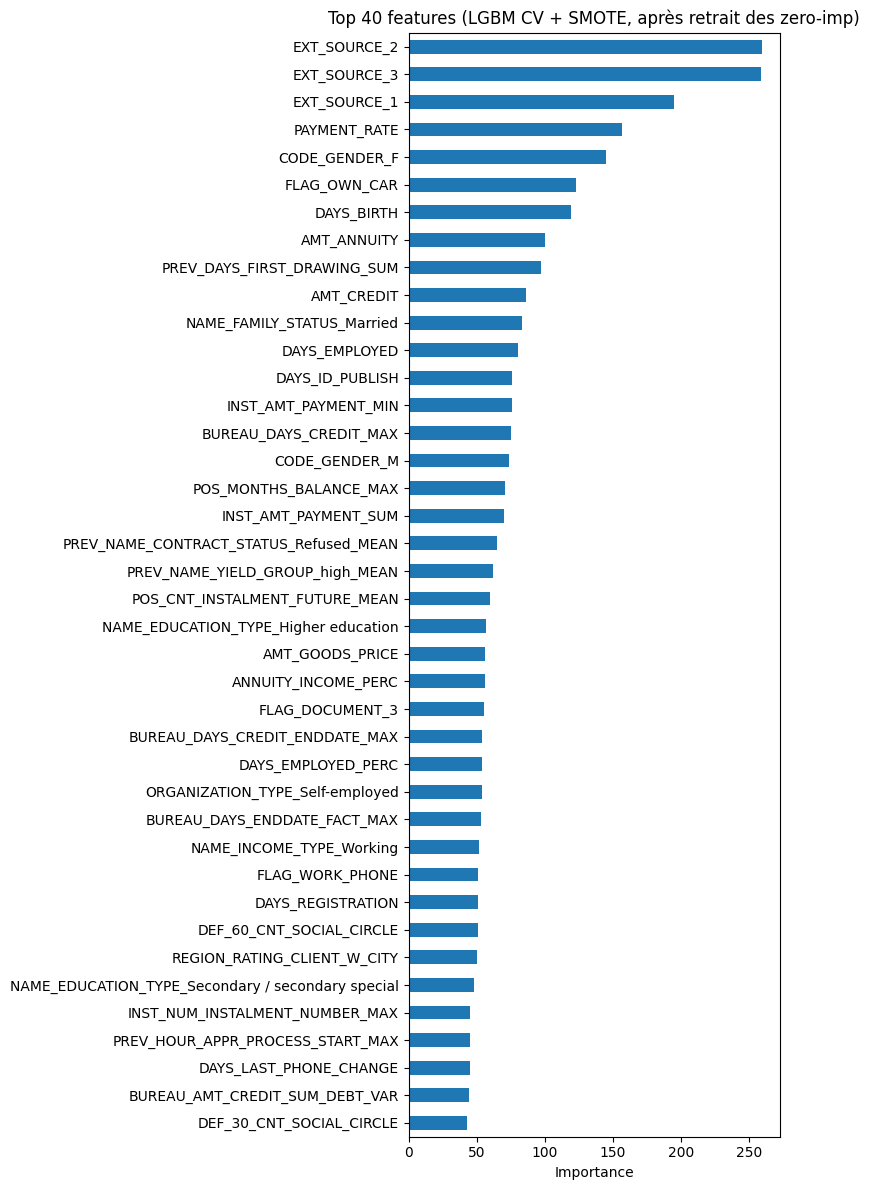

In [31]:
top_k = 40
top_imp = importances_nozero.head(top_k)

plt.figure(figsize=(8, 12))
top_imp[::-1].plot(kind="barh")
plt.title("Top 40 features (LGBM CV + SMOTE, après retrait des zero-imp)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [32]:
imp = importances_nozero

imp_norm = imp / imp.sum()
cum_imp = imp_norm.cumsum()

print("Cumul importance pour les 20 premières :")
print(cum_imp.head(20))

print("\nCumul pour les dernières :")
print(cum_imp.tail(10))


Cumul importance pour les 20 premières :
EXT_SOURCE_2                              0.028889
EXT_SOURCE_3                              0.057667
EXT_SOURCE_1                              0.079333
PAYMENT_RATE                              0.096778
CODE_GENDER_F                             0.112889
FLAG_OWN_CAR                              0.126556
DAYS_BIRTH                                0.139778
AMT_ANNUITY                               0.150889
PREV_DAYS_FIRST_DRAWING_SUM               0.161667
AMT_CREDIT                                0.171222
NAME_FAMILY_STATUS_Married                0.180444
DAYS_EMPLOYED                             0.189333
DAYS_ID_PUBLISH                           0.197778
INST_AMT_PAYMENT_MIN                      0.206222
BUREAU_DAYS_CREDIT_MAX                    0.214556
CODE_GENDER_M                             0.222778
POS_MONTHS_BALANCE_MAX                    0.230667
INST_AMT_PAYMENT_SUM                      0.238444
PREV_NAME_CONTRACT_STATUS_Refused_MEAN   

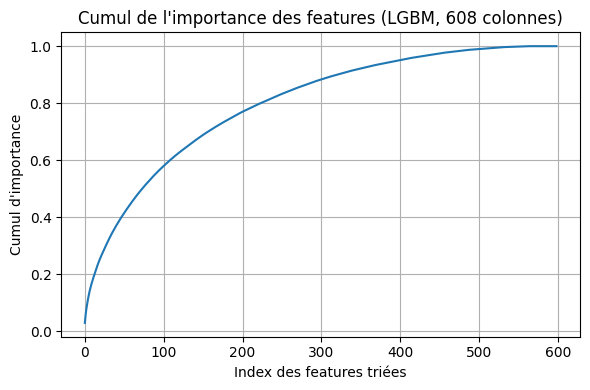

In [33]:
plt.figure(figsize=(6, 4))
plt.plot(cum_imp.values)
plt.xlabel("Index des features triées")
plt.ylabel("Cumul d'importance")
plt.title("Cumul de l'importance des features (LGBM, 608 colonnes)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
zero_imp2 = importances_nozero[importances_nozero == 0.0]
print("Nouvelles features à importance nulle :", len(zero_imp2))
print(zero_imp2.head(20))


Nouvelles features à importance nulle : 37
REG_REGION_NOT_WORK_REGION                        0
ORGANIZATION_TYPE_Government                      0
WEEKDAY_APPR_PROCESS_START_WEDNESDAY              0
CCB_SK_DPD_DEF_SUM                                0
OCCUPATION_TYPE_Cooking staff                     0
LIVE_REGION_NOT_WORK_REGION                       0
CCB_AMT_DRAWINGS_OTHER_CURRENT_SUM                0
CCB_AMT_DRAWINGS_CURRENT_SUM                      0
PREV_CODE_REJECT_REASON_VERIF_MEAN                0
PREV_NAME_GOODS_CATEGORY_Gardening_MEAN           0
PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN    0
PREV_CODE_REJECT_REASON_SCO_MEAN                  0
ELEVATORS_MODE                                    0
BUREAU_BB_MONTHS_BALANCE_MAX_SUM                  0
BUREAU_BB_MONTHS_BALANCE_MAX_MAX                  0
FLAG_DOCUMENT_5                                   0
BUREAU_CNT_CREDIT_PROLONG_VAR                     0
FLOORSMIN_MODE                                    0
NAME_EDUCATION_TYPE_A

In [35]:
X_nozero2 = X.drop(columns=zero_imp2.index)

print("Shape avant :", X.shape)
print("Shape après :", X_nozero2.shape)

# On remplace X par ce nouveau dataset plus propre
X = X_nozero2


Shape avant : (307511, 599)
Shape après : (307511, 562)


In [36]:
lgbm_cv_nozero2 = LGBMClassifier(
    objective="binary",
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

res_lgbm_cv_smote_nozero2 = run_model_cv(
    name="lgbm_cv_smote_nozero2",
    estimator=lgbm_cv_nozero2,
    X=X,
    y=y,
    model_name="lgbm",
    n_splits=3,
    use_sampling=True,
    smote_ratio=0.2,
    use_under=False,
)


2026/01/21 20:17:58 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 20:17:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 20:18:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 20:18:04 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.398063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138318
[LightGBM] [Info] Number of data points in the train set: 226148, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609449
[LightGBM] [Info] Start training from score -1.609449


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 20:19:02 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 20:19:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 20:19:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 20:19:08 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.438744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138273
[LightGBM] [Info] Number of data points in the train set: 226148, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609449
[LightGBM] [Info] Start training from score -1.609449


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 20:20:06 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 20:20:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 20:20:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 20:20:12 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.404300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138342
[LightGBM] [Info] Number of data points in the train set: 226149, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166664 -> initscore=-1.609454
[LightGBM] [Info] Start training from score -1.609454


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[lgbm_cv_smote_nozero2] AUC OOF=0.781 | AP OOF=0.272 | F1 OOF=0.069 (thr=0.5) | mean folds AUC=0.781, AP=0.272, F1=0.069


In [37]:
# X et y = tes données déjà prêtes (561 features, TARGET)
X_sub, _, y_sub, _ = train_test_split(
    X, y,
    train_size=50_000,      # à ajuster si tu veux moins / plus
    stratify=y,
    random_state=42,
)

print(X_sub.shape, y_sub.mean())


(50000, 562) 0.08072


In [38]:
lgbm_base = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,   # threads internes LGBM (ok)
)

param_distributions = {
    "num_leaves": [31, 63],            # moins de valeurs
    "min_child_samples": [50, 100, 200],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "reg_lambda": [0.0, 1.0, 5.0],
    "reg_alpha": [0.0, 1.0],
    "n_estimators": [200, 400],        # plus petit que 600
    "learning_rate": [0.03, 0.05, 0.1],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_distributions,
    n_iter=10,                  # 10 combinaisons au lieu de 20
    scoring="average_precision",
    cv=cv,
    n_jobs=1,                   # IMPORTANT : 1 seul process joblib
    verbose=2,
    random_state=42,
)

random_search.fit(X_sub.values, y_sub.values)

print("Best AP (CV subset):", random_search.best_score_)
print("Best params:", random_search.best_params_)
best_lgbm_params = random_search.best_params_


2026/01/21 20:20:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '100b427df9ea4ad7917302cdd3cc6af0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=0.0, subsample=0.7; total time=   4.7s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=0.0, subsample=0.7; total time=   4.5s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=0.0, subsample=0.7; total time=   4.4s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=31, reg_alpha=0.0, reg_lambda=0.0, subsample=0.7; total time=   4.5s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=31, reg_alpha=0.0, reg_lambda=0.0, subsample=0.7; total time=   4.1s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=31, reg_alpha=0.0, reg_lambda=0.0, subsample=0.7; total time=   4.2s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time=   4.8s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time=   5.6s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time=   5.4s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=63, reg_alpha=1.0, reg_lambda=1.0, subsample=0.9; total time=   6.9s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=63, reg_alpha=1.0, reg_lambda=1.0, subsample=0.9; total time=   7.0s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=63, reg_alpha=1.0, reg_lambda=1.0, subsample=0.9; total time=   6.7s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, min_child_samples=50, n_estimators=200, num_leaves=63, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time=   8.9s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, min_child_samples=50, n_estimators=200, num_leaves=63, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time=   7.0s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, min_child_samples=50, n_estimators=200, num_leaves=63, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time=   7.2s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time=   4.4s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time=   4.6s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time=   4.4s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=200, num_leaves=63, reg_alpha=0.0, reg_lambda=5.0, subsample=0.9; total time=   7.7s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=200, num_leaves=63, reg_alpha=0.0, reg_lambda=5.0, subsample=0.9; total time=   7.6s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=200, num_leaves=63, reg_alpha=0.0, reg_lambda=5.0, subsample=0.9; total time=   7.1s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=5.0, subsample=0.7; total time=   4.5s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=5.0, subsample=0.7; total time=   4.5s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, min_child_samples=50, n_estimators=200, num_leaves=31, reg_alpha=1.0, reg_lambda=5.0, subsample=0.7; total time=   5.1s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.03, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=0.0, reg_lambda=5.0, subsample=0.9; total time=   5.5s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.03, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=0.0, reg_lambda=5.0, subsample=0.9; total time=   5.3s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.03, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=0.0, reg_lambda=5.0, subsample=0.9; total time=   5.1s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94350
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432459
[LightGBM] [Info] Start training from score -2.432459


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   4.7s
[LightGBM] [Info] Number of positive: 2690, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94167
[LightGBM] [Info] Number of data points in the train set: 33333, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080701 -> initscore=-2.432863
[LightGBM] [Info] Start training from score -2.432863


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   4.5s
[LightGBM] [Info] Number of positive: 2691, number of negative: 30643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94322
[LightGBM] [Info] Number of data points in the train set: 33334, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080728 -> initscore=-2.432491
[LightGBM] [Info] Start training from score -2.432491


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=31, reg_alpha=0.0, reg_lambda=0.0, subsample=0.9; total time=   4.6s
[LightGBM] [Info] Number of positive: 4036, number of negative: 45964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96812
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080720 -> initscore=-2.432604
[LightGBM] [Info] Start training from score -2.432604


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 20:24:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, b

Best AP (CV subset): 0.2461523257894582
Best params: {'subsample': 0.9, 'reg_lambda': 5.0, 'reg_alpha': 1.0, 'num_leaves': 63, 'n_estimators': 200, 'min_child_samples': 50, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


In [39]:
lgbm_tuned = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    **best_lgbm_params,
)

res_lgbm_cv_smote_tuned = run_model_cv(
    name="lgbm_cv_smote_tuned",
    estimator=lgbm_tuned,
    X=X,          # tes 307 511 lignes, 561 features "propres"
    y=y,
    model_name="lgbm",
    n_splits=3,
    use_sampling=True,
    smote_ratio=0.2,
    use_under=False,   # on garde la meilleure config (SMOTE seul)
)

res_lgbm_cv_smote_tuned


2026/01/21 20:24:44 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 20:24:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 20:24:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 20:24:49 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.437963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138318
[LightGBM] [Info] Number of data points in the train set: 226148, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609449
[LightGBM] [Info] Start training from score -1.609449


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 20:25:48 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 20:25:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 20:25:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 20:25:54 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138273
[LightGBM] [Info] Number of data points in the train set: 226148, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609449
[LightGBM] [Info] Start training from score -1.609449


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 20:27:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 20:27:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 20:27:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 20:27:06 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.416307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138342
[LightGBM] [Info] Number of data points in the train set: 226149, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166664 -> initscore=-1.609454
[LightGBM] [Info] Start training from score -1.609454


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[lgbm_cv_smote_tuned] AUC OOF=0.775 | AP OOF=0.262 | F1 OOF=0.038 (thr=0.5) | mean folds AUC=0.775, AP=0.262, F1=0.038


{'name': 'lgbm_cv_smote_tuned',
 'oof_auc': 0.7749942806952888,
 'oof_ap': 0.26160887158369195,
 'oof_precision': 0.5967940813810111,
 'oof_recall': 0.019496475327291037,
 'oof_f1': 0.03775940084256514,
 'oof_accuracy': 0.9197817313852188,
 'oof_bal_acc': 0.5091698574113515,
 'oof_pred_pos_rate': 0.002637304031400503,
 'auc_folds': [0.7753298455049359, 0.7766432762198949, 0.7730738863516364],
 'ap_folds': [0.26670455930136083, 0.26059282569643266, 0.25834600319341855],
 'f1_folds': [0.03633806118860626, 0.03952291861552853, 0.03741377294516544],
 'fold_metrics': [{'fold': 1.0,
   'auc': 0.7753298455049359,
   'ap': 0.26670455930136083,
   'f1': 0.03633806118860626},
  {'fold': 2.0,
   'auc': 0.7766432762198949,
   'ap': 0.26059282569643266,
   'f1': 0.03952291861552853},
  {'fold': 3.0,
   'auc': 0.7730738863516364,
   'ap': 0.25834600319341855,
   'f1': 0.03741377294516544}],
 'pipeline': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('scaler', Standa

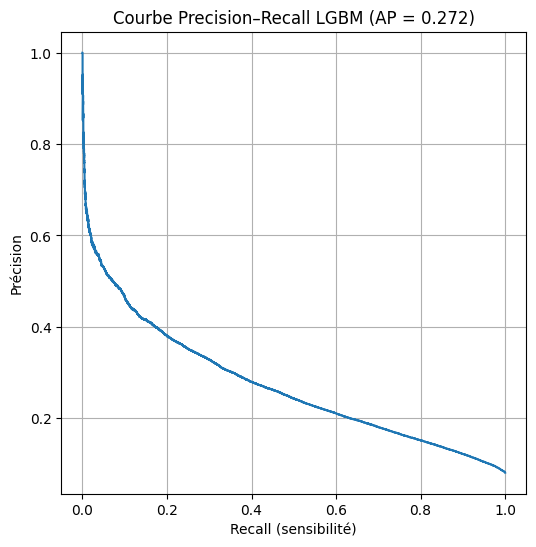

In [40]:
y_true = res_lgbm_cv_smote_nozero2["y_true"]
y_scores = res_lgbm_cv_smote_nozero2["oof_probas"]

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.xlabel("Recall (sensibilité)")
plt.ylabel("Précision")
plt.title(f"Courbe Precision–Recall LGBM (AP = {ap:.3f})")
plt.grid(True)
plt.show()

In [41]:
y_true = res_lgbm_cv_smote_nozero2["y_true"]
y_scores = res_lgbm_cv_smote_nozero2["oof_probas"]

res_thr_80 = pick_threshold_for_recall(y_true, y_scores, target_recall=0.80)
res_thr_80

{'threshold': 0.06259528609163434,
 'precision': 0.15174901049864756,
 'recall': 0.8,
 'f1': 0.25510761148112704,
 'cm': array([[171672, 111014],
        [  4965,  19860]])}

In [42]:
for target_recall in [0.70, 0.80, 0.85]:
    res_thr = pick_threshold_for_recall(y_true, y_scores, target_recall)
    if res_thr is not None:
        print(
            f"Recall cible {target_recall:.2f} -> "
            f"seuil={res_thr['threshold']:.3f}, "
            f"precision={res_thr['precision']:.3f}, "
            f"recall={res_thr['recall']:.3f}, "
            f"f1={res_thr['f1']:.3f}"
        )


Recall cible 0.70 -> seuil=0.085, precision=0.181, recall=0.700, f1=0.287
Recall cible 0.80 -> seuil=0.063, precision=0.152, recall=0.800, f1=0.255
Recall cible 0.85 -> seuil=0.052, precision=0.137, recall=0.850, f1=0.237


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# y_true : ta TARGET réelle (Series)
# y_scores : tes scores OOF lightGBM (probas de défaut)
# ex : y_true = y
#      y_scores = y_scores_oof  # si tu l'as conservé

C_FP = 1.0   # coût de refuser un bon client
C_FN = 10.0  # coût de laisser passer un défaut

def cost_for_threshold(y_true, y_scores, thr, c_fp=1.0, c_fn=10.0):
    y_pred = (y_scores >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = c_fp * fp + c_fn * fn
    avg_cost = total_cost / len(y_true)
    return {
        "threshold": thr,
        "total_cost": total_cost,
        "avg_cost": avg_cost,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
    }

thresholds = np.linspace(0.01, 0.5, 200)  # par ex. on regarde surtout les petites proba
results = [cost_for_threshold(y, y_scores, thr, C_FP, C_FN) for thr in thresholds]

# On cherche le seuil avec le coût moyen minimal
best = min(results, key=lambda d: d["avg_cost"])
best


{'threshold': np.float64(0.08879396984924623),
 'total_cost': np.float64(152795.0),
 'avg_cost': np.float64(0.49687653449795294),
 'tn': np.int64(208561),
 'fp': np.int64(74125),
 'fn': np.int64(7867),
 'tp': np.int64(16958)}

In [44]:
# 1) Base = ton meilleur modèle actuel
lgbm_base = LGBMClassifier(
    objective="binary",
    n_estimators=300,      # valeur de ton meilleur modèle
    learning_rate=0.05,   # idem
    num_leaves=31,        # idem
    subsample=0.8,        # idem
    colsample_bytree=0.8, # idem
    random_state=42,
    n_jobs=-1,            # parallélisme interne LightGBM
)

# 2) On fait varier autour de ces valeurs
param_distributions = {
    # autour de 31 feuilles
    "num_leaves": [31, 40, 50],

    # régularisation de la taille des feuilles
    "min_child_samples": [50, 100, 200],

    # autour de 0.8
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],

    # régularisation L2 / L1
    "reg_lambda": [0.0, 1.0, 5.0],
    "reg_alpha": [0.0, 0.5, 1.0],

    # autour de 300 arbres et 0.05 de LR
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.03, 0.05, 0.07],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_distributions,
    n_iter=10,                 # tu peux mettre 8 si tu veux limiter encore
    scoring="average_precision",
    cv=cv,
    n_jobs=1,                  # IMPORTANT : 1 seul process joblib
    verbose=2,
    random_state=42,
)

# ⚠️ ici on utilise TOUT le dataset, plus le subset :
# et on passe .values pour éviter les histoires de noms de colonnes LightGBM
random_search.fit(X.values, y.values)

print("Best AP (CV full):", random_search.best_score_)
print("Best params:", random_search.best_params_)

best_lgbm_params = random_search.best_params_
best_lgbm_params


2026/01/21 20:27:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a2099dbbeef841d1a200ec8bd15a1f0a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.450084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, min_child_samples=50, n_estimators=300, num_leaves=40, reg_alpha=1.0, reg_lambda=1.0, subsample=0.9; total time=  50.1s
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.502083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, min_child_samples=50, n_estimators=300, num_leaves=40, reg_alpha=1.0, reg_lambda=1.0, subsample=0.9; total time= 1.1min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.452941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.05, min_child_samples=50, n_estimators=300, num_leaves=40, reg_alpha=1.0, reg_lambda=1.0, subsample=0.9; total time= 1.3min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.463691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=40, reg_alpha=0.5, reg_lambda=5.0, subsample=0.9; total time=  53.5s
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.525385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=40, reg_alpha=0.5, reg_lambda=5.0, subsample=0.9; total time=  40.9s
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.413213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=100, n_estimators=200, num_leaves=40, reg_alpha=0.5, reg_lambda=5.0, subsample=0.9; total time= 1.0min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.452486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=300, num_leaves=40, reg_alpha=0.5, reg_lambda=5.0, subsample=0.7; total time= 1.6min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.570826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=300, num_leaves=40, reg_alpha=0.5, reg_lambda=5.0, subsample=0.7; total time= 1.0min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.447664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=300, num_leaves=40, reg_alpha=0.5, reg_lambda=5.0, subsample=0.7; total time= 1.0min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.426358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=300, num_leaves=31, reg_alpha=0.0, reg_lambda=5.0, subsample=0.8; total time=  58.0s
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.533184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=300, num_leaves=31, reg_alpha=0.0, reg_lambda=5.0, subsample=0.8; total time=  49.3s
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.836600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=300, num_leaves=31, reg_alpha=0.0, reg_lambda=5.0, subsample=0.8; total time= 2.0min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.789557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.07, min_child_samples=50, n_estimators=300, num_leaves=40, reg_alpha=1.0, reg_lambda=0.0, subsample=0.8; total time= 2.2min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.845170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.07, min_child_samples=50, n_estimators=300, num_leaves=40, reg_alpha=1.0, reg_lambda=0.0, subsample=0.8; total time= 1.9min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.799678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.07, min_child_samples=50, n_estimators=300, num_leaves=40, reg_alpha=1.0, reg_lambda=0.0, subsample=0.8; total time= 1.2min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.818150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, min_child_samples=50, n_estimators=400, num_leaves=31, reg_alpha=0.5, reg_lambda=1.0, subsample=0.9; total time= 1.3min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.921859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, min_child_samples=50, n_estimators=400, num_leaves=31, reg_alpha=0.5, reg_lambda=1.0, subsample=0.9; total time= 1.6min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.792906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, min_child_samples=50, n_estimators=400, num_leaves=31, reg_alpha=0.5, reg_lambda=1.0, subsample=0.9; total time= 1.5min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.860839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=200, n_estimators=300, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 1.5min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.856761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=200, n_estimators=300, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 1.5min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.788364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=200, n_estimators=300, num_leaves=50, reg_alpha=0.5, reg_lambda=0.0, subsample=0.8; total time= 1.9min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.852076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.07, min_child_samples=100, n_estimators=400, num_leaves=40, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time= 1.4min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.846400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.07, min_child_samples=100, n_estimators=400, num_leaves=40, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time= 1.6min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.781792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.07, min_child_samples=100, n_estimators=400, num_leaves=40, reg_alpha=0.0, reg_lambda=0.0, subsample=0.8; total time= 1.5min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.861103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, min_child_samples=100, n_estimators=400, num_leaves=50, reg_alpha=0.0, reg_lambda=5.0, subsample=0.8; total time= 1.4min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.811576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, min_child_samples=100, n_estimators=400, num_leaves=50, reg_alpha=0.0, reg_lambda=5.0, subsample=0.8; total time= 1.9min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.975226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.03, min_child_samples=100, n_estimators=400, num_leaves=50, reg_alpha=0.0, reg_lambda=5.0, subsample=0.8; total time= 1.9min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.813257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100868
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=400, num_leaves=50, reg_alpha=0.5, reg_lambda=5.0, subsample=0.7; total time= 1.6min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.846319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100932
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=400, num_leaves=50, reg_alpha=0.5, reg_lambda=5.0, subsample=0.7; total time= 1.9min
[LightGBM] [Info] Number of positive: 16550, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.823350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100821
[LightGBM] [Info] Number of data points in the train set: 205008, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432489
[LightGBM] [Info] Start training from score -2.432489


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, min_child_samples=50, n_estimators=400, num_leaves=50, reg_alpha=0.5, reg_lambda=5.0, subsample=0.7; total time= 1.6min
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.253941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100799
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 21:15:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, b

Best AP (CV full): 0.28107792718293473
Best params: {'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'num_leaves': 50, 'n_estimators': 400, 'min_child_samples': 100, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


{'subsample': 0.8,
 'reg_lambda': 5.0,
 'reg_alpha': 0.0,
 'num_leaves': 50,
 'n_estimators': 400,
 'min_child_samples': 100,
 'learning_rate': 0.03,
 'colsample_bytree': 0.7}

In [45]:
lgbm_tuned_full = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    **best_lgbm_params,
)

res_lgbm_cv_smote_tuned_full = run_model_cv(
    name="lgbm_cv_smote_tuned_full",
    estimator=lgbm_tuned_full,
    X=X,
    y=y,
    model_name="lgbm",
    n_splits=3,
    use_sampling=True,
    smote_ratio=0.2,
    use_under=False,
)

res_lgbm_cv_smote_tuned_full


2026/01/21 21:19:28 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 21:19:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 21:19:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 21:19:39 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.792625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138318
[LightGBM] [Info] Number of data points in the train set: 226148, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609449
[LightGBM] [Info] Start training from score -1.609449


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 21:22:20 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 21:22:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 21:22:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 21:22:32 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.800308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138273
[LightGBM] [Info] Number of data points in the train set: 226148, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609449
[LightGBM] [Info] Start training from score -1.609449


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2026/01/21 21:24:57 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 21:24:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 21:25:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 21:25:06 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 37691, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.813275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138342
[LightGBM] [Info] Number of data points in the train set: 226149, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166664 -> initscore=-1.609454
[LightGBM] [Info] Start training from score -1.609454


c:\Users\thoma\Documents\Openclassroom\Projet-8\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[lgbm_cv_smote_tuned_full] AUC OOF=0.783 | AP OOF=0.275 | F1 OOF=0.073 (thr=0.5) | mean folds AUC=0.783, AP=0.275, F1=0.073


{'name': 'lgbm_cv_smote_tuned_full',
 'oof_auc': 0.7834378874744781,
 'oof_ap': 0.2747131022020172,
 'oof_precision': 0.5691768826619965,
 'oof_recall': 0.03927492447129909,
 'oof_f1': 0.07347953877458738,
 'oof_accuracy': 0.920041884680548,
 'oof_bal_acc': 0.5183321269873529,
 'oof_pred_pos_rate': 0.005570532436238053,
 'auc_folds': [0.7839900449502737, 0.7841038744751129, 0.7822660021004526],
 'ap_folds': [0.28127444073167684, 0.27317443152816034, 0.27057342293363384],
 'f1_folds': [0.07205982324949015, 0.07767867223664898, 0.07069452286843592],
 'fold_metrics': [{'fold': 1.0,
   'auc': 0.7839900449502737,
   'ap': 0.28127444073167684,
   'f1': 0.07205982324949015},
  {'fold': 2.0,
   'auc': 0.7841038744751129,
   'ap': 0.27317443152816034,
   'f1': 0.07767867223664898},
  {'fold': 3.0,
   'auc': 0.7822660021004526,
   'ap': 0.27057342293363384,
   'f1': 0.07069452286843592}],
 'pipeline': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('scaler', Stan

In [46]:
res = res_lgbm_cv_smote_tuned_full  # ton dict

y_true = res["y_true"]
y_scores = res["oof_probas"]

# 1) Courbe PR
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# 2) Choix de seuil orienté métier (par ex. recall >= 0.80)
res_thr_80 = pick_threshold_for_recall(y_true, y_scores, target_recall=0.80)
res_thr_80


{'threshold': 0.06222596479063815,
 'precision': 0.1534408294767096,
 'recall': 0.8,
 'f1': 0.2574940358883933,
 'cm': array([[173115, 109571],
        [  4965,  19860]])}

In [47]:
thresholds = np.linspace(0.01, 0.5, 200)

results_cost = [
    cost_for_threshold(y_true, y_scores, thr, C_FP, C_FN)
    for thr in thresholds
]

best_cost = min(results_cost, key=lambda d: d["avg_cost"])
best_cost


{'threshold': np.float64(0.09371859296482411),
 'total_cost': np.float64(152162.0),
 'avg_cost': np.float64(0.49481807154866003),
 'tn': np.int64(214594),
 'fp': np.int64(68092),
 'fn': np.int64(8407),
 'tp': np.int64(16418)}

In [49]:
# 1) Modèle final = meilleurs hyperparamètres trouvés
lgbm_final = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    **best_lgbm_params,   # dict issu de ton RandomizedSearch full dataset
)

final_pipe = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(sampling_strategy=0.2, random_state=42)),
    ("model", lgbm_final),
])

mlflow.set_experiment("home-credit-benchmark")

with mlflow.start_run(run_name="lgbm_champion_frozen"):
    mlflow.set_tag("stage", "champion_v1")
    mlflow.set_tag("model", "lgbm")
    mlflow.set_tag("validation", "cv_smote_full")
    mlflow.set_tag("feature_set", "v1_all_tables_nozero2")

    # hyperparamètres
    mlflow.log_params({f"lgbm_{k}": v for k, v in best_lgbm_params.items()})
    mlflow.log_param("smote_ratio", 0.2)

    # métriques CV (issues de res_lgbm_cv_smote_tuned_full)
    mlflow.log_metric("auc_oof", float(res_lgbm_cv_smote_tuned_full["oof_auc"]))
    mlflow.log_metric("ap_oof", float(res_lgbm_cv_smote_tuned_full["oof_ap"]))
    mlflow.log_metric("f1_oof", float(res_lgbm_cv_smote_tuned_full["oof_f1"]))

    # seuil métier (à adapter avec tes valeurs finales)
    mlflow.log_param("thr_recall_0.80", 0.06222596479063815)
    mlflow.log_param("thr_cost_optimal", 0.09371859296482411)

    # 2) Fit final sur tout le dataset
    final_pipe.fit(X, y)

    # 3) Log du pipeline complet dans MLflow
    mlflow.sklearn.log_model(final_pipe, artifact_path="model")


2026/01/21 23:37:44 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2026/01/21 23:37:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2026/01/21 23:37:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/21 23:37:49 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[LightGBM] [Info] Number of positive: 56537, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.593149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138319
[LightGBM] [Info] Number of data points in the train set: 339223, number of used features: 562
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609441
[LightGBM] [Info] Start training from score -1.609441


2026/01/21 23:38:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/21 23:38:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
